**Table of contents**<a id='toc0_'></a>    
- 1. [Giới thiệu dataset:](#toc1_)    
  - 1.1. [A. Tổng quan](#toc1_1_)    
    - 1.1.1. [log:](#toc1_1_1_)    
    - 1.1.2. [split](#toc1_1_2_)    
    - 1.1.3. [Công dụng của các cột và khi nào thì drop chúng:](#toc1_1_3_)    
  - 1.2. [B. Quan sát train_log](#toc1_2_)    
    - 1.2.1. [Nhận xét:](#toc1_2_1_)    
  - 1.3. [C. Quan sát split folder (**flux_correct func**)](#toc1_3_)    
    - 1.3.1. [Quan sát raw](#toc1_3_1_)    
    - 1.3.2. [Thử join log và split để sửa Flux](#toc1_3_2_)    
    - 1.3.3. [Biểu đồ Flux và sai số, theo thời gian đo đạc](#toc1_3_3_)    
- 2. [Thống kê về thời gian quan sát](#toc2_)    
    - 2.1.1. [Đầu tiên, ta cần một hàm để liên kết được log và split một cách cẩn thận hơn bản sample trước đó ( note vào mục "Last" rồi )](#toc2_1_1_)    
    - 2.1.2. [Một quy trình để khảo sát các thông số đáng lưu tâm về thời điểm dữ liệu được thu thập thôi](#toc2_1_2_)    
    - 2.1.3. [Nhận xét:](#toc2_1_3_)    
- 3. [Khảo sát, thực hiện phân cụm thời điểm quan sát](#toc3_)    
    - 3.1.1. [*** Nhận xét:](#toc3_1_1_)    
- 4. [Last: Tổng hợp một số hàm hữu ích](#toc4_)    
  - 4.1. [Hàm làm sạch flux](#toc4_1_)    
  - 4.2. [Hàm liên kết log và splits](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path

# Preparation for correct Flux (explain later)
!pip -q install extinction==0.4.7
from extinction import fitzpatrick99
WAVELENGTHS = { ## sourced from SVO Filter Profile Service
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}


## Chuẩn bị dir (để truy cập file khi cần)
dirname = {
    'root': './kaggle/input', # input dir
    'working': './kaggle/working/',   # current session's saving file dir
}
train_sp_name = 'train_full_lightcurves.csv'
test_sp_name = 'test_full_lightcurves.csv'


## Load thử file
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file

split_01 = pd.read_csv(
    path.join( dirname['root'], 'split_01', train_sp_name ))


## Xử lý p.1 
train_log = train_log.drop(['English Translation'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. <a id='toc1_'></a>[Giới thiệu dataset:](#toc0_)

Giới thiệu sơ bộ về dataset, dịch và tóm lược thay cho mục "Data" trong competition.

## 1.1. <a id='toc1_1_'></a>[A. Tổng quan](#toc0_)

### 1.1.1. <a id='toc1_1_1_'></a>[log:](#toc0_)

Có 2 file log là train_log và test_log, trong đó train_log đã được ban tổ chức modify lại một chút để thuận tiện cho các nhóm tham gia. Về các dòng dữ liệu, ta sẽ giải thích sơ lược như sau:

- <strong>object_id</strong> : tên Latin của thiên thể theo cú pháp 3 phần Sindarin (ta không cần quan tâm cụ thể, biết nó là UNIQUE ID là được)

- <del><strong>English Translation</strong></del> : tên tiếng anh của thiên thể (thêm cho vui thôi, ta sẽ drop hẳn cột này)

- <strong>Z</strong> : std độ dịch chuyển đỏ (spectroscopic redshift values), liên quan tới khoảng cách từ thiên thể đó tới Trái Đất

- <strong>Z_err</strong> : variance (độ lệch chuẩn) của Z do sai số đo đạc.
      </br>Trong train_log, Z đã được làm sạch, nên mặc định ta cho bằng <strong>0</strong> (người ta để bằng NaN, phải fillna lại).
      </br>Nhưng trong test_log thì ngược lại, độ lệch khoảng 3%.
      </br><i>=> Lúc train model thì chưa cần quan tâm Z_err. Nhưng khi predict cho tập test thì ta sẽ xử lý thêm cho nó sau.</i>
      
- <strong>split</strong> : tên của split folder, bên trong là một bảng riêng dạng Time Series, thu thập trong thời gian quan sát thiên thể. Mô tả chi tiết ở mục sau

- <strong>target</strong> : giá trị 0 hoặc 1, là nhãn cần dự đoán (xem liệu thiên thể này có thuộc loại <strong>TDE</strong> hay không). Như đã nói bài này dạng <strong>Binary Classification</strong> (phân loại nhị phân).

- <strong>SpecType</strong> : cái này bổ sung cho target thôi, mấy ổng để cho mình biết là nếu không phải TDE (nhãn 0) thì nó có thể thuộc nhiều SpecType khác nhau nữa.

- <strong>EBV</strong> : một dạng thông số để làm sạch Flux (trong split), tùy model và mức độ khai thác, ta cũng có thể lược hẳn chỉ số này sau khi sử dụng xong.

### 1.1.2. <a id='toc1_1_2_'></a>[split](#toc0_)

Mỗi object_id sẽ được trỏ tới 1 folder. Và mỗi folder thì chứa TimeSeries của nhiều object gộp chung lại với nhau (tại vì mỗi object cũng chỉ có khoảng chục lần quan sát là nhiều rồi).

- <strong>object_id</strong> : tên Latin của thiên thể, tương ứng với file log.
  </br>Lưu ý: ánh xạ 1-n. Một object có nhiều dòng trong split (Time Series), đại diện cho những thời điểm quan sát khác nhau, bằng ống kính (filter) khác nhau.
  
- <strong>Time (MJD)</strong> : ngày thực hiện quan sát, theo <strong>Modified Julian Date</strong> (một dạng chuẩn hóa ngày thành Integer, để ta không phải quan tâm về tháng thừa năm thiếu nữa)

- <strong>Flux</strong> : cường độ sáng quan sát được (tại Trái Đất), theo đơn vị microjansky (μJy). Cái này cần làm sạch dựa trên thông số <strong>EBV</strong> (ở trên).
    </br>[Phương pháp lọc Flux](https://colab.research.google.com/drive/1N7Q1bxc2gxBuOv2eD3fTYsrxoLC2dQAP#scrollTo=06314127) (cung cấp bởi ban tổ chức, hơi chuyên môn)
    </br>=>Sau khi làm sạch Flux thì ta có thể bỏ hẳn 2 cột <strong>EBV, Filter</strong>

- <strong>Flux_err</strong> : độ lệch sai số của Flux

- <strong>Filter</strong> : một thiên thể (cùng một thời điểm) có thể được quan sát bởi nhiều loại ống kình khác nhau. Có 6 loại filter đánh dấu dưới dạng 1 char.

### 1.1.3. <a id='toc1_1_3_'></a>[Công dụng của các cột và khi nào thì drop chúng:](#toc0_)

- Để làm sạch Flux: log \[ 'EBV' \] ++ split \[ 'Flux', 'Filter' \]
    </br> Sau khi làm sạch, ta có thể drop Flux cũ (dính bụi), và drop EBV

- Để khai thác thông tin thời gian: split \[ 'Time MJD' \]
    </br> Chuyển thành các dạng vector, chênh lệch ngày,... thì ta có thể bỏ qua số MJD chuẩn


## 1.2. <a id='toc1_2_'></a>[B. Quan sát train_log](#toc0_)

In [2]:
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file


## Xử lý p.1 
train_log = train_log.drop(['English Translation'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)

train_log

,object_id,Z,Z_err,EBV,SpecType,split,target
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0
1,Dornhoth_galadh_ylf,0.4324,0.0,0.058,SN II,split_01,0
2,Elrim_melethril_thul,0.4673,0.0,0.577,AGN,split_01,0
3,Ithil_tobas_rodwen,0.6946,0.0,0.012,AGN,split_01,0
4,Mirion_adar_Druadan,0.4161,0.0,0.058,AGN,split_01,0
...,...,...,...,...,...,...,...
3038,tinnu_gellui_tathar,0.8898,0.0,0.042,AGN,split_20,0
3039,uir_heleg_corf,0.9598,0.0,0.042,AGN,split_20,0
3040,uir_rhosc_law,0.1543,0.0,0.024,SN II,split_20,0
3041,uruk_in_pess,1.1520,0.0,0.019,AGN,split_20,0


### 1.2.1. <a id='toc1_2_1_'></a>[Nhận xét:](#toc0_)
Từ bảng cross-tab bên dưới:
</br>Thì như đã nói, target=1 tương đương với SpecType "TDE". Tuy nhiên, ta chỉ không ngờ là tỉ lệ nhãn lại lệch quá mức như vậy. Bias này có thể ảnh hưởng tới cách tiếp cận bài toán của ta dưới một vài dạng:

- Chia training_set và validating_set trong quá trình thực hiện (tra cứu kỹ nha).

- Về đánh lại nhãn. Tra cứu chi tiết về các SpecType, ta có thể gộp một số phân loại nhỏ vào một nhóm lớn hơn, giúp đơn giản hóa mô hình cũng như giảm overfitting.
  
- Xác định bài toán. Yêu cầu cuối là Binary Classification. Nhưng ta có thể tiếp cận theo dạng Binary (phân loại trực tiếp 0/1), hoặc Multi-classes Classification (phân loại chi tiết theo SpecType, và lọc lại kết quả theo yêu cầu)

- ...

<strong>Lưu ý:</strong> không cần áp dụng toàn bộ các dự định trên ngay từ đầu, mà ưu tiên ứng dụng dần dần từ trên xuống dưới. Nhiều khi overthinking quá cũng không tốt đâu mom

In [3]:
pd.crosstab(
    index=train_log['SpecType'],  # Các giá trị này sẽ thành HÀNG (index)
    columns=train_log['target'],  # Các giá trị này sẽ thành CỘT (columns)
    margins=True          # margin=True nếu bạn muốn thêm cột/hàng 'All' tổng cộng
)

target,0,1,All
SpecType,,,
AGN,1786,0,1786
SLSN-I,15,0,15
SLSN-II,10,0,10
SN II,163,0,163
SN IIP,6,0,6
SN IIb,8,0,8
SN IIn,41,0,41
SN Ia,790,0,790
SN Ia-91T-like,17,0,17


## 1.3. <a id='toc1_3_'></a>[C. Quan sát split folder (**flux_correct func**)](#toc0_)

### 1.3.1. <a id='toc1_3_1_'></a>[Quan sát raw](#toc0_)

In [4]:
split_01 = pd.read_csv(
    path.join( dirname['root'], 'split_01', train_sp_name ))

# lấy sample một object
sample_object_id = 'amon_imloth_luin'

sample_log = train_log[ train_log['object_id'] == sample_object_id ]
sample_split = split_01[ split_01['object_id'] == sample_object_id ]

sample_split

,object_id,Time (MJD),Flux,Flux_err,Filter
2073,amon_imloth_luin,63899.3404,2.657700,0.255077,i
2074,amon_imloth_luin,63923.7373,1.314073,0.101607,r
2075,amon_imloth_luin,63904.2198,3.549463,0.475724,z
2076,amon_imloth_luin,63916.4182,1.443035,0.206576,r
2077,amon_imloth_luin,63923.7373,1.492297,0.150162,i
...,...,...,...,...,...
2187,amon_imloth_luin,63152.7974,0.146727,0.181362,r
2188,amon_imloth_luin,63186.9530,-0.083325,0.102353,g
2189,amon_imloth_luin,63191.8324,0.258550,0.941367,y
2190,amon_imloth_luin,63206.4705,0.135038,0.130768,r


### 1.3.2. <a id='toc1_3_2_'></a>[Thử join log và split để sửa Flux](#toc0_)

In [5]:
# join vào thành 1 bảng tổng hợp
sample_full_series = pd.merge(
                        left= sample_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                        right= sample_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                        on='object_id',          # Cột dùng để nối (Khóa chung)
                        how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
                    ).dropna()

sample_full_series.head(5)

,object_id,Z,Z_err,EBV,SpecType,split,target,Time (MJD),Flux,Flux_err,Filter
0,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63899.3404,2.657700,0.255077,i
1,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63923.7373,1.314073,0.101607,r
2,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63904.2198,3.549463,0.475724,z
3,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63916.4182,1.443035,0.206576,r
4,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63923.7373,1.492297,0.150162,i


In [6]:
## will need "import fitzpatrick99 from extinction" (on the up-top)
#-------------------------------------------------------------#
def jurassic_park(row):
    """Áp dụng hiệu chỉnh tuyệt chủng cho mỗi dòng."""
    # Lấy bước sóng hiệu dụng dựa trên Filter
    eff_wl = np.array([ WAVELENGTHS.get(row['Filter']) ])

    # Kiểm tra xem có Filter hợp lệ không
    if eff_wl is None:
        # Nếu filter không hợp lệ, trả về Flux gốc
        return row['Flux']

    # Tính A_lambda (mức độ tuyệt chủng ở bước sóng - lambda)
    A_lambda = fitzpatrick99(eff_wl, row['EBV'] * 3.1) # with 3.1 is Standard Milky Way value

    # Công thức hiệu chỉnh: Flux_hiệu_chỉnh = Flux_quan_sát * 10^(A_lambda / 2.5)
    flux_ext = row['Flux'] * 10**((A_lambda) / 2.5)

    return flux_ext
#-------------------------------------------------------------#


## áp dụng jurassic_park lên một DataFrame (bản full_series)
sample_full_series['Corrected Flux'] = sample_full_series.apply(
    jurassic_park, 
    axis=1, # Áp dụng trên từng hàng (row-wise)
    result_type='expand' # Mở rộng kết quả (tuple) thành các cột riêng biệt
)

sample_full_series

,object_id,Z,Z_err,EBV,SpecType,split,target,Time (MJD),Flux,Flux_err,Filter,Corrected Flux
0,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63899.3404,2.657700,0.255077,i,2.927328
1,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63923.7373,1.314073,0.101607,r,1.498455
2,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63904.2198,3.549463,0.475724,z,3.827528
3,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63916.4182,1.443035,0.206576,r,1.645513
4,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63923.7373,1.492297,0.150162,i,1.643693
...,...,...,...,...,...,...,...,...,...,...,...,...
114,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63152.7974,0.146727,0.181362,r,0.167314
115,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63186.9530,-0.083325,0.102353,g,-0.100870
116,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63191.8324,0.258550,0.941367,y,0.274156
117,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01,1,63206.4705,0.135038,0.130768,r,0.153985


### 1.3.3. <a id='toc1_3_3_'></a>[Biểu đồ Flux và sai số, theo thời gian đo đạc](#toc0_)

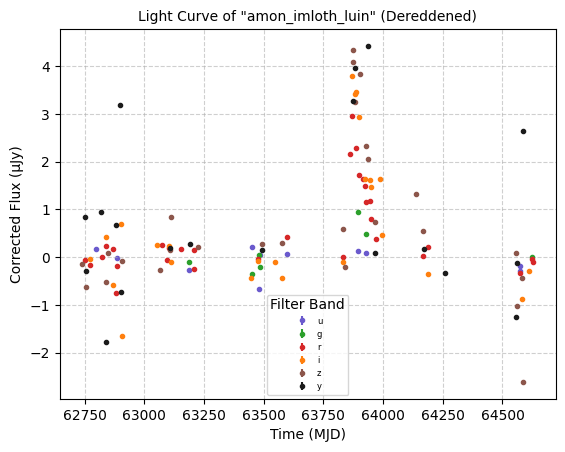

In [17]:
filters_list = ['u', 'g', 'r', 'i', 'z', 'y']
# filters_list = ['r'] # ghi đè để plot mỗi filter này thôi
show_error = False


#Setting filter colours for later plotting
filter_colours = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}

for index, current_filter in enumerate(filters_list, start=1):
    # Lọc dữ liệu chỉ cho bộ lọc hiện tại
    df_f = sample_full_series[sample_full_series['Filter'] == current_filter]
    
    color = filter_colours.get(current_filter, 'gray') # Lấy màu, mặc định là xám nếu không tìm thấy

    # Tạo biểu đồ Error Bar
    plt.errorbar(
        x= df_f['Time (MJD)'],          # Trục hoành: Thời gian
        y= df_f['Corrected Flux'],     # Trục tung: Flux đã hiệu chỉnh
        yerr= df_f['Flux_err'] * show_error,        # Error bar: Độ lệch chuẩn
        fmt='.',                      # Định dạng điểm: Dùng chấm tròn ('.')
        color=color,                  # Màu sắc theo filter_colours
        label= current_filter,        # Nhãn cho chú giải
        # capsize=1,                    # Kích thước mũ của error bar
        # markersize=1,                 # Kích thước điểm đánh dấu
        # elinewidth=1,                # Độ dày của đường error bar
        zorder= index
    )

plt.xlabel('Time (MJD)', fontsize=10)
plt.ylabel('Corrected Flux (μJy)', fontsize=10)
plt.title(f'Light Curve of "{sample_object_id}" (Dereddened)', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Filter Band', fontsize=6)

plt.show()

# 2. <a id='toc2_'></a>[Thống kê về thời gian quan sát](#toc0_)

### 2.1.1. <a id='toc2_1_1_'></a>[Đầu tiên, ta cần một hàm để liên kết được log và split một cách cẩn thận hơn bản sample trước đó ( note vào mục "Last" rồi )](#toc0_)

In [29]:
## Hàm abstract cho đa tác vụ luôn nha
from typing import Callable

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df

def right_join(df_log, df_split) :
    """right join df_log vào df_split, tạo ra 1 dataframe dạng full_series ấy"""
    return pd.merge(
                left= df_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                right= df_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                on='object_id',          # Cột dùng để nối (Khóa chung)
                how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
            ).dropna()

def basic_process(df_log:pd.DataFrame, df_split:pd.DataFrame) :
    df_full_join = right_join(df_log, df_split)

    df_full_join['Flux'] = df_full_join.apply(jurassic_park, 
                                              axis=1, result_type='expand')
    
    return df_full_join

### 2.1.2. <a id='toc2_1_2_'></a>[Một quy trình để khảo sát các thông số đáng lưu tâm về thời điểm dữ liệu được thu thập thôi](#toc0_)

In [30]:
def summarize_time_series_by_filter(df_input: pd.DataFrame) -> pd.DataFrame:
    """
    Thực hiện thống kê chuỗi thời gian (Time MJD) cho từng cặp object_id và Filter.

    Returns:
        DataFrame kết quả với mỗi hàng là một cặp (object_id, Filter) và các thống kê.
    """
    
    # 1. Nhóm dữ liệu theo object_id và Filter
    grouped = df_input.groupby(['object_id', 'Filter'])
    
    # 2. Định nghĩa các phép tổng hợp (aggregation) cơ bản
    # Các phép này được áp dụng trực tiếp lên cột 'Time (MJD)'
    agg_dict = {
        'Time (MJD)': [
            ('record_number', 'count'),  # Số lượng bản ghi
            ('first_mjd', 'min'),        # Ngày đầu tiên
            ('last_mjd', 'max'),         # Ngày cuối cùng
        ]
    }
    
    df_stats = grouped.agg(agg_dict)
    
    # Đặt lại tên cột cho gọn gàng (loại bỏ multi-index)
    df_stats.columns = ['_'.join(col).strip() for col in df_stats.columns.values]
    
    # 3. Tính Duration (Khoảng cách giữa ngày đầu và ngày cuối)
    df_stats['duration'] = df_stats['Time (MJD)_last_mjd'] - df_stats['Time (MJD)_first_mjd']
    
    # 4. Tính toán Time Delta Statistics (Thống kê khoảng cách giữa 2 bản ghi liên tiếp)
    
    # Hàm tùy chỉnh để tính time delta statistics
    def calculate_time_delta_stats(series: pd.Series) -> pd.Series:
        """Tính std, var, mean, min, max của khoảng cách thời gian giữa các bản ghi."""
        
        # Sắp xếp lại chuỗi thời gian để đảm bảo tính toán đúng
        sorted_times = series.sort_values().values
        
        if len(sorted_times) < 2:
            # Nếu chỉ có 0 hoặc 1 bản ghi, không thể tính delta
            return pd.Series(
                [0.0] * 5, 
                index=['time_delta_std', 'time_delta_var', 'time_delta_mean', 'time_delta_min', 'time_delta_max']
            )

        # Tính khoảng cách giữa các bản ghi liên tiếp
        time_deltas = np.diff(sorted_times)
        
        # Trả về các thông số thống kê
        return pd.Series({
            'time_delta_std': time_deltas.std(),
            'time_delta_var': time_deltas.var(),
            'time_delta_mean': time_deltas.mean(),
            'time_delta_min': time_deltas.min(),
            'time_delta_max': time_deltas.max()
        })

    # Áp dụng hàm tùy chỉnh lên cột 'Time (MJD)' của từng nhóm
    df_delta_stats = grouped['Time (MJD)'].apply(calculate_time_delta_stats).unstack()
    
    # 5. Nối các thống kê lại
    df_result = df_stats.join(df_delta_stats)
    
    # Đặt lại index để 'object_id' và 'Filter' trở thành các cột thông thường
    df_result = df_result.reset_index()
    
    # 6. Đổi tên cột cuối cùng cho rõ ràng
    df_result.rename(columns={
        'Time (MJD)_record_number': 'record_number',
        'Time (MJD)_first_mjd': 'first_day',
        'Time (MJD)_last_mjd': 'last_day'
    }, inplace=True)

    return df_result

def time_statistic_pipeline (df_log, df_split) :
    stats_features = summarize_time_series_by_filter(df_split)
    return right_join(df_log, stats_features)



In [31]:
time_statistic = process_and_combine_splits(train_log, train_sp_name,time_statistic_pipeline)

time_statistic

,object_id,Z,Z_err,EBV,SpecType,split,target,Filter,record_number,first_day,last_day,duration,time_delta_std,time_delta_var,time_delta_mean,time_delta_min,time_delta_max
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0,g,6,63380.4806,64075.8313,695.3507,128.357033,16475.527938,139.070140,35.2077,369.6801
1,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0,i,15,63327.6691,64471.9171,1144.2480,149.101850,22231.361620,81.732000,4.4010,594.1288
2,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0,r,16,63380.4806,64568.7381,1188.2575,112.041516,12553.301379,79.217167,4.4010,440.0954
3,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0,u,5,63719.3540,64568.7381,849.3841,304.372546,92642.646913,212.346025,26.4057,739.3602
4,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01,0,y,11,63314.4662,64555.5353,1241.0691,92.142955,8490.324244,124.106910,8.8020,264.0572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18220,ylf_alph_mindon,0.5595,0.0,0.034,SN Ia-91T-like,split_20,0,i,40,62792.1990,64623.1911,1830.9921,62.777440,3941.007024,46.948515,2.3656,224.7342
18221,ylf_alph_mindon,0.5595,0.0,0.034,SN Ia-91T-like,split_20,0,r,39,62768.5428,64623.1911,1854.6483,77.822617,6056.359784,48.806534,2.3656,347.7465
18222,ylf_alph_mindon,0.5595,0.0,0.034,SN Ia-91T-like,split_20,0,u,17,62856.0708,64575.8786,1719.8078,147.375111,21719.423418,107.487987,2.3656,499.1465
18223,ylf_alph_mindon,0.5595,0.0,0.034,SN Ia-91T-like,split_20,0,y,30,62751.9834,64587.7068,1835.7234,100.958493,10192.617336,63.300807,2.3656,361.9403


In [32]:
def plot_feature_distribution(
    df: pd.DataFrame,
    stat_name: str,
    spec_type_filter,
    plot_filter,
    bins: int = 30
):
    """
    Lọc dữ liệu theo Filter và vẽ biểu đồ phân phối của một đặc trưng thống kê.

    Args:
        df: DataFrame chứa các thống kê (ví dụ: final_summary_df).
        stat_name: Tên cột đặc trưng cần vẽ (ví dụ: 'duration', 'time_delta_mean').
        plot_filter: Giá trị Filter cần lọc (ví dụ: 'r', 'g', 'i').
        bins: Số lượng bin cho Histogram.
    """
    
    # 1. Lọc dữ liệu theo Filter
    # Đảm bảo cột Filter tồn tại
    if 'Filter' not in df.columns:
        print("Lỗi: DataFrame không có cột 'Filter'.")
        return

    # Lọc các hàng có giá trị cột 'Filter' bằng plot_filter
    df_filtered = df[ df['Filter'].isin(plot_filter) * df['SpecType'].isin(spec_type_filter)]
    
    # Lấy chuỗi dữ liệu (Series) cần vẽ
    if stat_name not in df_filtered.columns:
        print(f"Lỗi: DataFrame không có cột đặc trưng '{stat_name}'.")
        return
        
    data_series = df_filtered[stat_name]
    data_series = data_series.replace([np.inf, -np.inf], np.nan).dropna()

    if data_series.empty:
        print(f"Không có dữ liệu hợp lệ cho {stat_name} trong Filter {plot_filter}.")
        return

    min_val = data_series.min()
    max_val = data_series.max()
    
    # 2. Bắt đầu vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    
    # Sử dụng sns.histplot để vẽ Histogram và KDE
    sns.histplot(
        data=data_series,
        bins=bins,                      # Số lượng bin
        # kde=True,                       # Vẽ đường ước tính mật độ hạt nhân (KDE)
        color='#1f77b4',                # Màu sắc cho biểu đồ
        edgecolor='black',              # Viền của các thanh histogram
        line_kws={'linewidth': 1.5},    # Độ dày của đường KDE
        binrange=(min_val, max_val)
    )

    # 3. Thiết lập giao diện biểu đồ
    plt.title(f'Distribution of "{stat_name}" for Filter: {plot_filter}, {spec_type_filter} (divided into: {bins})', fontsize=12)
    plt.xlabel(stat_name, fontsize=14)
    plt.ylabel('Frequency (Tần suất)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()

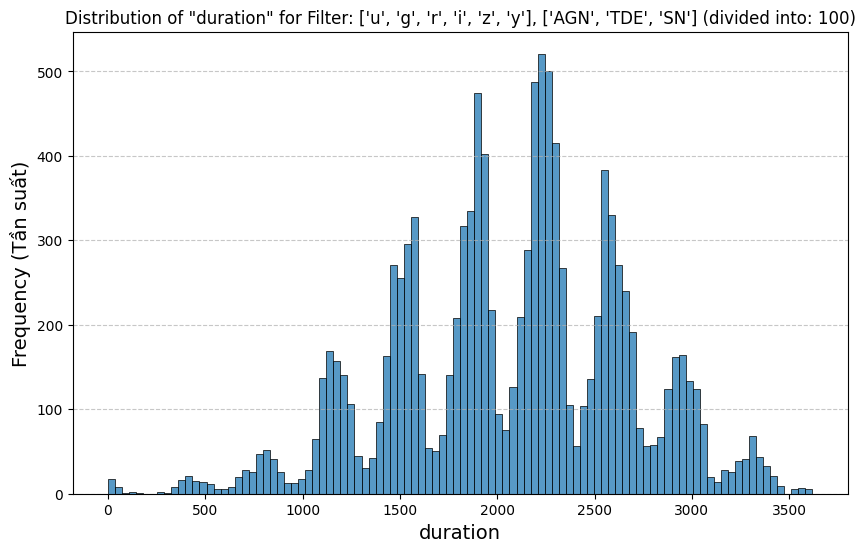

In [33]:
filters_list = ['u', 'g', 'r', 'i', 'z', 'y']

plot_feature_distribution(
    time_statistic,    # cố dịnh
    'duration',  # tên cột để lấy dữ liệu vẽ distribution
    ['AGN', 'TDE', 'SN'],    # list tên SpecType, tự tìm list đầy đủ nha
    ['u', 'g', 'r', 'i', 'z', 'y'],             # list tên filter được sử dụng để quan sát
    100,               # bin, chia biểu đồ thành n cột
)

### 2.1.3. <a id='toc2_1_3_'></a>[Nhận xét:](#toc0_)
Tra cứu bảng và visualize cho bảng time_statistic, mà chủ yếu quan sát về record_number và duration, nhận thấy:

- Số record_number của mỗi cặp object-Filter khá là đa dạng, chủ yếu giao động ở mức 10-50 bản ghi, nhưng lại tồn tại ngoại lệ lên tới >200 bản ghi.

- Duration cũng thế, có vật thể chỉ được quan sát vài chục ngày (sát vạch 0), hoặc được quản sát rất lâu trong nhiều năm. Các đỉnh cục bộ trong biểu đồ cũng đáng chú ý, dường như đang cách nhau ~1 năm</br>
-> Giải thích: nguyên nhân là do thời điểm có thể quan sát 1 ngôi sao trong năm có giới hạn, ta cần đến một điều kiện thời tiết, và vị trí Trái Đất phù hợp để các quan sát có thể được thực hiện. Dẫn tới thông tin các bản ghi thường sẽ phân cụm, tương ứng với mùa (trong năm) phù hợp để đài thiên văn thực hiện quan sát của mình.

# 3. <a id='toc3_'></a>[Khảo sát, thực hiện phân cụm thời điểm quan sát](#toc0_)

In [40]:
#Setting filter colours for later plotting
filter_colours = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}    


def time_records_plot (
    ax:plt.axes,
    df_log: pd.DataFrame,
    set: str = 'train',
    filters_list = ['u', 'g', 'r', 'i', 'z', 'y'],
    show_error:float = 0
) :
    
    data = process_and_combine_splits(df_log, f'{set}_full_lightcurves.csv', basic_process)
    grouped_data = data.groupby('Filter')

    for index, current_filter in enumerate(filters_list, start=1):
        # Lọc dữ liệu chỉ cho bộ lọc hiện tại
        data_filter = grouped_data.get_group(current_filter)
        
        color = filter_colours.get(current_filter, 'gray') # Lấy màu, mặc định là xám nếu không tìm thấy

        # Tạo biểu đồ Error Bar
        ax.errorbar(
            x= data_filter['Time (MJD)'],          # Trục hoành: Thời gian
            y= data_filter['Flux'],     # Trục tung: Flux đã hiệu chỉnh
            yerr= data_filter['Flux_err'] * show_error ,        # Error bar: Độ lệch chuẩn
            fmt='.',                      # Định dạng điểm: Dùng chấm tròn ('.')
            color=color,                  # Màu sắc theo filter_colours
            label= current_filter,        # Nhãn cho chú giải
            # capsize=1,                    # Kích thước mũ của error bar
            # markersize=1,                 # Kích thước điểm đánh dấu
            # elinewidth=1,                # Độ dày của đường error bar
            zorder= index
        )

    ax.set_xlabel('Time (MJD)', fontsize=10)
    ax.set_ylabel('Flux (μJy)', fontsize=10)
    ax.set_title(df_log['SpecType'].head(1))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Filter Band', fontsize=6)


def time_distribution_plot (
    ax:plt.axes,
    df_log:pd.DataFrame,
    set:str = 'train',
    filters_list = ['u', 'g', 'r', 'i', 'z', 'y'],
) :

    data = process_and_combine_splits(df_log, f'{set}_full_lightcurves.csv', basic_process)
    grouped_data = data.groupby('Filter')

    for index, current_filter in enumerate(filters_list, start=1):
        # Lọc dữ liệu chỉ cho bộ lọc hiện tại
        data_filter = grouped_data.get_group(current_filter)

        time_points = data_filter['Time (MJD)'].sort_values(ascending=True)
        time_diff = ( time_points.shift(-1) - time_points ).dropna()

        time_diff_separation = np.mean(time_diff) + np.std(time_diff)

        color = filter_colours.get(current_filter, 'gray')

        ax.scatter(
            time_points[0:-1], 
            time_diff, 
            label=f'{current_filter} line={time_diff_separation:.1f}',
            s=3, # Kích thước điểm
            color=color,
            zorder= index
        )

        ax.axhline(
            y=time_diff_separation, 
            color=color, 
            linestyle='--', 
            linewidth=0.5,
        )

    ax.set_title(df_log['SpecType'].head(1))
    ax.set_xlabel('Time MJD', fontsize=10)
    ax.set_ylabel('Time Difference (MJD)', fontsize=10)
    ax.legend(title='Filter Band', fontsize=6)
    ax.grid(True, linestyle=':', alpha=0.6)

sample_log = train_log[train_log['object_id'].isin(['salab_tirith_Ithil', 'ungol_aeruil_heledh'])]

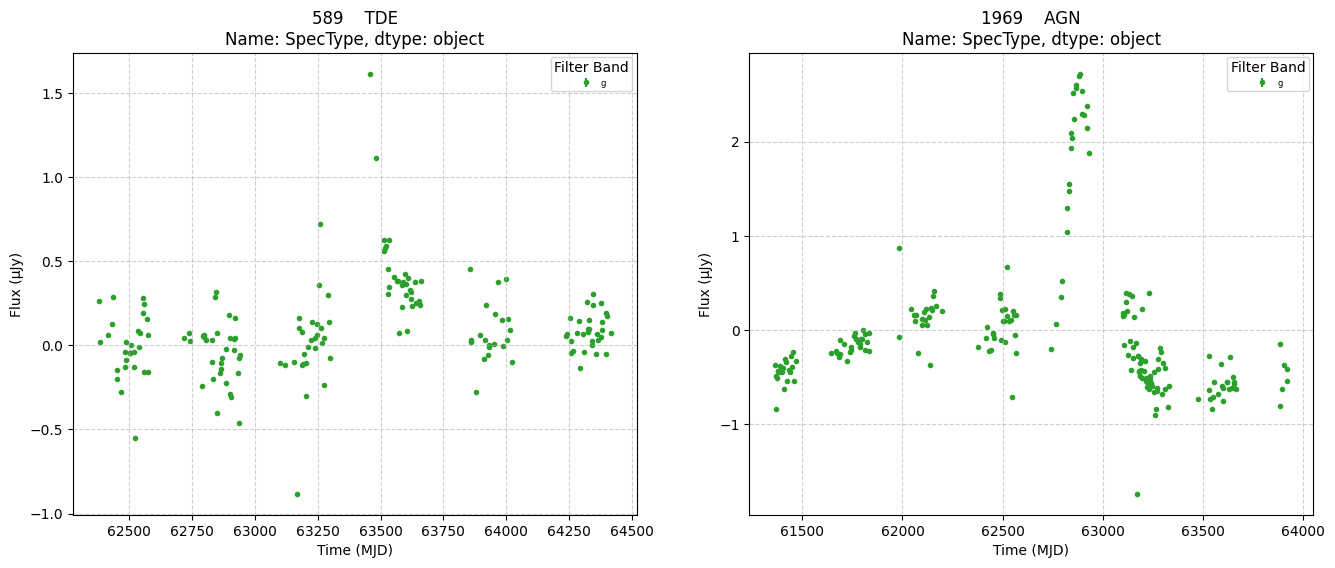

In [56]:
filters_list = ['i', 'u', 'y', 'r', 'g', 'z']
filters_list = ['g']

# Định nghĩa bố cục (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

i = 0
for index in sample_log.index :
    time_records_plot(
        ax=axes[i],
        df_log=pd.DataFrame(sample_log.loc[index]).T,
        filters_list=filters_list,
        show_error=0
    )
    i += 1



### 3.1.1. <a id='toc3_1_1_'></a>[*** Nhận xét:](#toc0_)

Thì như đã nói, dữ liệu được thực hiện quan sát theo mùa, nên ta có thể thấy được một số cụm dữ liệu tách biệt trong chuỗi thời gian quan sát. Việc phân lập được các cụm này có thể đem tới một số khả năng về chiến thuật khai thác đặc trưng (Features) sau này, hoặc tăng cường dữ liệu (Data Augmentation) nhằm chống lại thiên lệch nhãn. </br>

-> Nhưng câu hỏi là tách ra kiểu gì? </br>
-> Thực ra việc phân tách này không quá phức tạp, và có thể được thực hiện đơn giản với một kết quả tương đối, thông qua một đường phân tách cứng. Thông thường, con số 75-100 ngày cũng có thể áp dụng, hoặc nếu yêu cầu linh động hơn, ta có thể đổi qua mean_diff + std (phân vị 87%), hoặc quantile(0.9) (phân vị 90%).

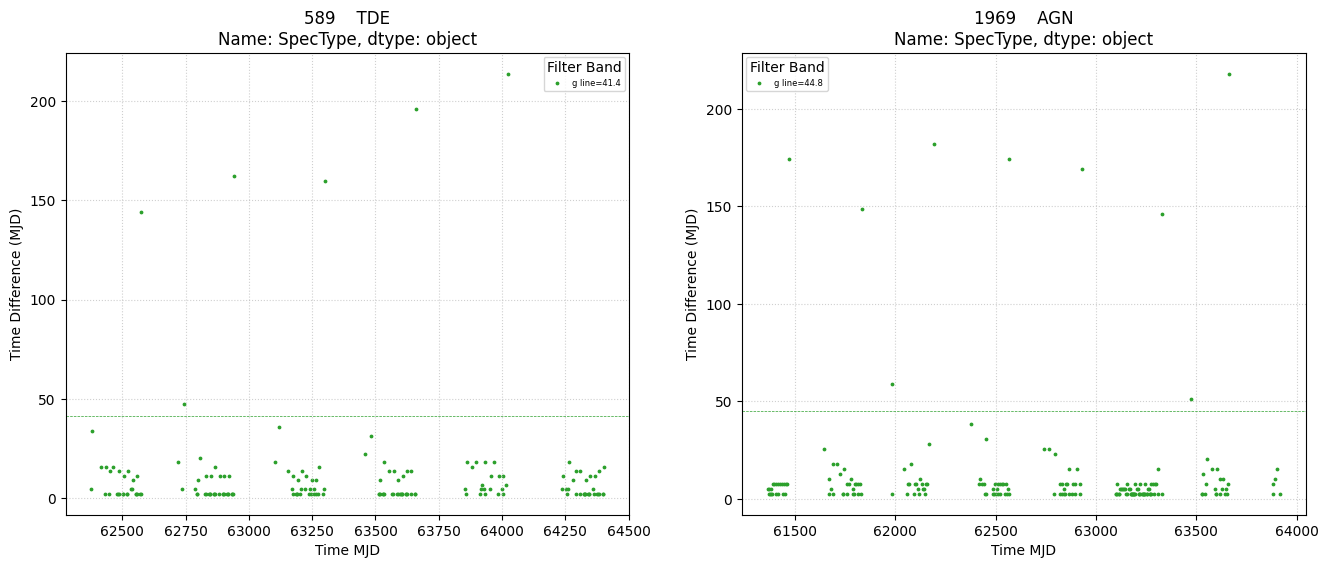

In [57]:
filters_list = ['u', 'g', 'r', 'i', 'z', 'y']
filters_list = ['g']

# Định nghĩa bố cục (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

i = 0
for index in sample_log.index :
    time_distribution_plot(
        ax=axes[i],
        df_log=pd.DataFrame(sample_log.loc[index]).T,
        filters_list=filters_list
    )
    i += 1

# 4. <a id='toc4_'></a>[Last: Tổng hợp một số hàm hữu ích](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Hàm làm sạch flux](#toc0_)

Chức năng: Nó apply vào bảng (sau khi đã merge log và split), để tính toán lại Flux chính xác (làm sạch Flux)

In [36]:
!pip -q install extinction==0.4.7
from extinction import fitzpatrick99

WAVELENGTHS = { 'u': 3641, 'g': 4704, 'r': 6155, 'i': 7504, 'z': 8695, 'y': 10056 }

#-------------------------------------------------------------#
def jurassic_park(row):
    """Áp dụng hiệu chỉnh tuyệt chủng cho mỗi dòng."""
    # Lấy bước sóng hiệu dụng dựa trên Filter
    eff_wl = np.array([ WAVELENGTHS.get(row['Filter']) ])

    # Kiểm tra xem có Filter hợp lệ không
    if eff_wl is None:
        # Nếu filter không hợp lệ, trả về Flux gốc
        return row['Flux']

    # Tính A_lambda (mức độ tuyệt chủng ở bước sóng - lambda)
    A_lambda = fitzpatrick99(eff_wl, row['EBV'] * 3.1) # with 3.1 is Standard Milky Way value

    # Công thức hiệu chỉnh: Flux_hiệu_chỉnh = Flux_quan_sát * 10^(A_lambda / 2.5)
    flux_ext = row['Flux'] * 10**((A_lambda) / 2.5)

    return flux_ext
#-------------------------------------------------------------#


## CÁCH DÙNG cho bảng full_series (ghi đè lên cột Flux hiện tại)
## Trong đó, một bảng full_series là bao gồm các cột: 
## [ object_id, Z, Z_err, **EBV**, SpecType, split,	target,	Time (MJD),	**Flux**, Flux_err,	**Filter** ]

sample_full_series['Flux'] = sample_full_series.apply(
    jurassic_park, 
    axis=1, # Áp dụng trên từng hàng (row-wise)
    result_type='expand' # Mở rộng kết quả (tuple) thành các cột riêng biệt
)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 4.2. <a id='toc4_2_'></a>[Hàm liên kết log và splits](#toc0_)

Chức năng: hàm nhận vào file log, và tự tách thành cách group nhỏ để liên kết với split tương ứng. Sau khi tách, nó sẽ tự áp dụng hàm 'callback_function (log_csv, split_csv). Sau đó hợp lại thành 1 bảng chung và trả về. Ở đây, hàm callback có thể đơn giản là right-join, hoặc các hàm phức tạp hơn để gắn kết 1 dòng log với split tương ứng của nó.
</br>=> Sử dụng hàm này thì tương đương dồn hết 20 split vào hết 1 file

In [37]:
from typing import Callable

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df